In [38]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm

%matplotlib inline

In [39]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(0xBADBEEF)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Our device is {device}")

Our device is cpu


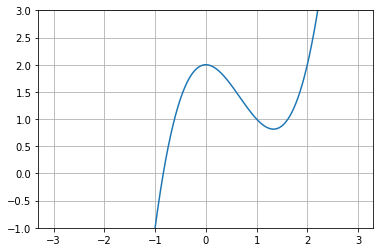

In [40]:
# Optimize one param - function in Pythorch
# min_O L(p_O(X), Y)
# L - loss
# p_O - neural network
# X - data of train
# Y - answers

# function
func = lambda x: x ** 3 - 2 * x ** 2 + 2
# differencial
d_func = lambda x: 3 * x ** 2 - 4 * x

x = np.linspace(-3, 3, 1000)
plt.figure(figsize=(6, 4))
plt.ylim([-1, 3])
plt.plot(x, func(x))
plt.grid()
plt.show()

In [41]:
def find_minimum_first_order(
        learning_rate = 0.01,
        eps = 1e-4,
        max_iterations=1000,
        anneal_learning_rate=None,
):
    i = 0
    x_old, x_new = 0, 2
    x_list, y_list = [x_old], [func(x_old)]
    if not anneal_learning_rate:
        anneal_learning_rate = lambda lr, step: lr

    while (i < max_iterations) and abs(x_new - x_old) > eps:
        learning_rate = anneal_learning_rate(learning_rate, step=1)
        x_old = x_new
        x_new -= d_func(x_old) * learning_rate 
        
        x_list.append(x_new)
        y_list.append(func(x_new))
        
        i += 1
        
    print("local minimum: ", x_new)
    print("number of steps: ", len(x_list))
    
    plt.figure(figsize=(6, 4))
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c='r', edgecolors='k')
    plt.plot(x_list, y_list, c='r')
    plt.plot(x, func(x), c='b')
    plt.title("Descent trajectory")
    plt.grid()
    plt.show()

local minimum:  1.3577577123861129
number of steps:  729


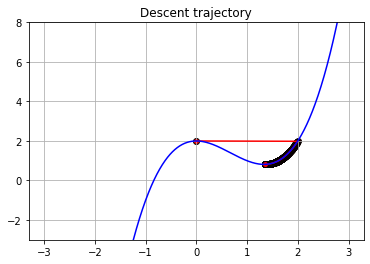

In [42]:
find_minimum_first_order(0.001)

local minimum:  1.3356881625009205
number of steps:  129


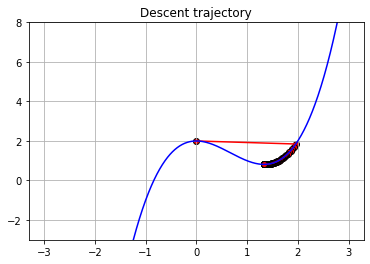

In [43]:
find_minimum_first_order(0.01)

local minimum:  1.3333495713163788
number of steps:  8


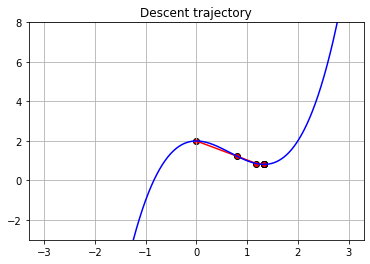

In [44]:
find_minimum_first_order(0.3)

In [11]:
find_minimum_first_order(0.6)

OverflowError: ignored

local minimum:  1.294744839667743
number of steps:  7


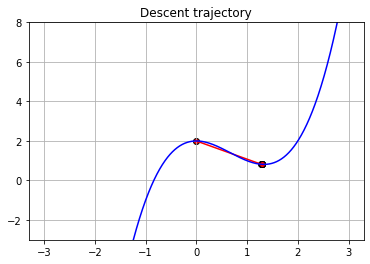

In [45]:
find_minimum_first_order(0.6, anneal_learning_rate=lambda lr, step: 0.3*lr)

In [46]:
[elem for elem in dir(torch.optim) if not elem.startswith("_")]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 'lr_scheduler',
 'swa_utils']

In [47]:
?torch.optim.SGD

In [48]:
model = torch.nn.Linear(1, 1)
list(model.named_parameters()), torch.optim.SGD(model.parameters(), lr=0.01
                )

([('weight', Parameter containing:
   tensor([[-0.1194]], requires_grad=True)), ('bias', Parameter containing:
   tensor([0.4259], requires_grad=True))], SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [49]:
[elem for elem in dir(torch.optim.lr_scheduler) if not elem.startswith("_")]

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

In [50]:
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler_func = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, scheduler_func)

In [51]:
def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.SGD(model.parameters(), lr=100)
    return simple_model, simple_optimizer

def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(100):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.ylabel('lr')
    plt.xlabel('step')
    plt.grid()
    plt.plot(range(100), lrs)

LambdaLR

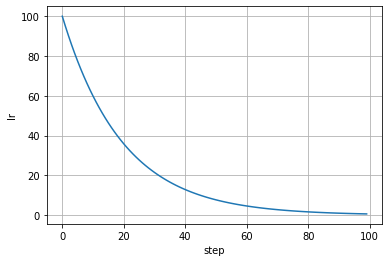

In [52]:
model, optimizer = get_simple_model_optimizer()
lambda_func = lambda epoch: 0.95 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
draw_learning_rate_curve(optimizer, scheduler)

# StepLR


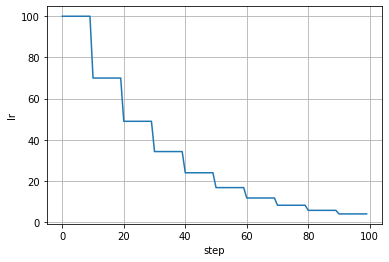

In [53]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
draw_learning_rate_curve(optimizer, scheduler)

# CosineAnnealingLR

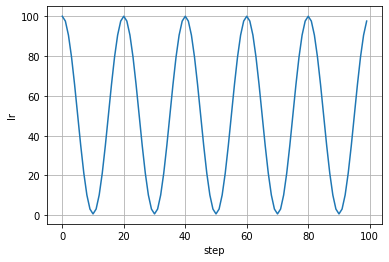

In [54]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.7)
draw_learning_rate_curve(optimizer, scheduler)

Pytorch vs Pytorch Lightning

In [55]:
from collections import defaultdict, namedtuple

import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy

Данные

In [56]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    "./data/",
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]))

train_dataloader = DataLoader(
    fashion_mnist_train,
    batch_size=128,
    shuffle=True,
    num_workers=4)

fashion_mnist_val = torchvision.datasets.FashionMNIST(
    "./data/",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]))

val_dataloader = DataLoader(
    fashion_mnist_val,
    batch_size=128,
    num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [57]:
idx_to_label = defaultdict(None, {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"}
)

Ankle Boot


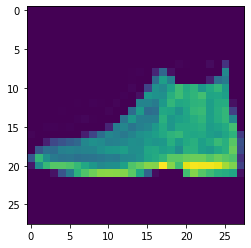

Coat


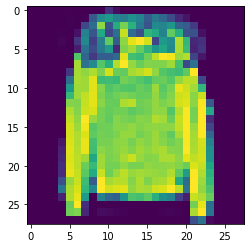

In [58]:
for batch in val_dataloader:
    images, class_nums = batch
    print(idx_to_label[int(class_nums[0])])
    plt.imshow(images[0].squeeze())
    plt.show()
    print(idx_to_label[int(class_nums[127])])
    plt.imshow(images[127].squeeze())
    plt.show()
    break

In [59]:
images[0].shape

torch.Size([1, 28, 28])

# Model

In [60]:
class SimpleNet(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        self.bn1 = torch.nn.BatchNorm2d(1)
        self.conv1 = torch.nn.Conv2d(1, 32, 3)
        self.relu = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.mp = torch.nn.MaxPool2d(2)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(64*5*5,128)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear2 = torch.nn.Linear(128, 64)
        self.linear3 = torch.nn.Linear(64, 10)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _foreward(self, x):
        x = self.bn1(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return 

    def foreward(self, images, target=None):
        output = self._foreward(images)

        if target is not None:
            loss = self.loss_func(output, target)
            self.targers = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()))
            self.accuracy = accuracy(self.preds.long(), self.targets.long())
        return loss
    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

# Hyper Parametrs

In [61]:
LossInfo = namedtuple(
    "LossInfo",
    ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)

EPOCHS = 10
LR = 0.001

# Train 

In [ ]:
def train_epoch(
    model,
    data_loader, 
    optimizer,
    return_losses=False,
    device="cuda:0"
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []

    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            accuracy = model.get_accuracy()
            prba